In [3]:
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Pal-ette/preprocessed_data/웰니스_대화_스크립트_데이터셋.csv")
df

,구분,유저
0,불안,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.
1,불안,더 이상 내 감정을 내가 컨트롤 못 하겠어.
2,불안,하루종일 오르락내리락 롤러코스터 타는 기분이에요.
3,불안,꼭 롤러코스터 타는 것 같아요.
4,불안,롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.
...,...,...
1449,상처,너무 지친다…
1450,상처,갈수록 지쳐요…
1451,상처,그 짓도 한두 번이지…
1452,상처,이제 저도 한계가 온 거 같아요.


In [6]:
def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " 's", string)
    string = re.sub(r"\'ve", " 've", string)
    string = re.sub(r"n\'t", " n't", string)
    string = re.sub(r"\'re", " 're", string)
    string = re.sub(r"\'d", " 'd", string)
    string = re.sub(r"\'ll", " 'll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip() if TREC else string.strip().lower()

['항에스트로겐을', '먹은지', '한', '달', '됐는데', ',', '갑자기', '오전에', '기분이', '완전', '가라앉고', ',', '만사가', '다', '귀찮은', '거야', '그러다', '점심', '때되니까', '기분이', '좀', '나아지더라고']
y_bin: ['공포' '기쁨' '놀람' '당황' '분노' '불안' '상처' '슬픔']


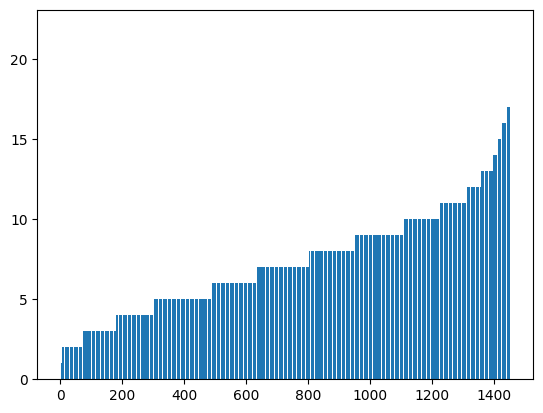

In [7]:
def make_xy(dataframe):
    x = dataframe["유저"]
    x = x.map(lambda x: clean_str(x).split())
    print(x[x.str.len().sort_values(ascending=False).index][252])
    y = dataframe["구분"]
    y_bin = LabelBinarizer()
    y_bin.fit(y)
    print("y_bin:", y_bin.classes_)
    y = y_bin.transform(y)
    return x, y, y_bin

x, y, y_bin = make_xy(df)

lens = sorted([len(t) for t in x])
plt.bar(range(len(lens)), lens)
plt.show()

In [8]:
x_train_src, x_test_src, y_train, y_test = train_test_split(x, y, train_size=0.7)

In [9]:
vocab_size = 2_000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train_src)
x_train_seq = tokenizer.texts_to_sequences(x_train_src)
x_test_seq = tokenizer.texts_to_sequences(x_test_src)

seq_length = 20
x_train_pad = keras.preprocessing.sequence.pad_sequences(x_train_seq,
                                                         maxlen=seq_length)
x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test_seq,
                                                        maxlen=seq_length)

In [10]:
input_layer = keras.layers.Input(shape=x_train_pad.shape[1:])  # 2D

outputs = keras.layers.Embedding(vocab_size, 100)(input_layer)  # 2D -> 3D
outputs = keras.layers.LSTM(50, return_sequences=False)(outputs)  # 3D -> 2D
outputs = keras.layers.Dense(y_bin.classes_.shape[0], activation='softmax')(outputs)

model = keras.Model(inputs=input_layer, outputs=outputs)

print('x_train_pad:', x_train_pad.shape)
model.summary()

x_train_pad: (1017, 20)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 100)           200000    
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 8)                 408       
                                                                 
Total params: 230608 (900.81 KB)
Trainable params: 230608 (900.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=keras.losses.categorical_crossentropy,
              metrics='acc')

model.fit(x_train_pad, y_train,
          epochs=100,
          batch_size=128,
          validation_data=(x_test_pad, y_test))

Epoch 1/100
8/8 [==============================] - 4s 152ms/step - loss: 2.0507 - acc: 0.2301 - val_loss: 2.0015 - val_acc: 0.3112
Epoch 2/100
8/8 [==============================] - 0s 48ms/step - loss: 1.9277 - acc: 0.3481 - val_loss: 1.8141 - val_acc: 0.2746
Epoch 3/100
8/8 [==============================] - 0s 49ms/step - loss: 1.7308 - acc: 0.2930 - val_loss: 1.7611 - val_acc: 0.2883
Epoch 4/100
8/8 [==============================] - 0s 44ms/step - loss: 1.6693 - acc: 0.3038 - val_loss: 1.7441 - val_acc: 0.2563
Epoch 5/100
8/8 [==============================] - 0s 42ms/step - loss: 1.6321 - acc: 0.3589 - val_loss: 1.7294 - val_acc: 0.2815
Epoch 6/100
8/8 [==============================] - 0s 45ms/step - loss: 1.5895 - acc: 0.4730 - val_loss: 1.6951 - val_acc: 0.3982
Epoch 7/100
8/8 [==============================] - 0s 49ms/step - loss: 1.5143 - acc: 0.5270 - val_loss: 1.6630 - val_acc: 0.4119
Epoch 8/100
8/8 [==============================] - 0s 43ms/step - loss: 1.4142 - acc: 0.5

In [12]:
# 모델 저장
model.save("/content/drive/MyDrive/Pal-ette/trained_models/ryugibo_model.keras")

# 토크나이저 저장
f = open("/content/drive/MyDrive/Pal-ette/trained_models/ryugibo_tokenizer.pickle", 'wb')
pickle.dump(tokenizer, f)
f.close()

# 라벨 저장
f = open("/content/drive/MyDrive/Pal-ette/trained_models/ryugibo_label_binarizer.pickle", 'wb')
pickle.dump(y_bin, f)
f.close()

# 기타 정보 저장
f = open("/content/drive/MyDrive/Pal-ette/trained_models/ryugibo_config.pickle", "wb")
pickle.dump({"seq_length": seq_length}, f)
f.close()

In [17]:
!ls -al "/content/drive/MyDrive/Pal-ette/trained_models/" | grep ryugibo_

-rw------- 1 root root      30 Apr 16 02:04 ryugibo_config.pickle
-rw------- 1 root root     386 Apr 16 02:04 ryugibo_label_binarizer.pickle
-rw------- 1 root root 2797997 Apr 16 02:04 ryugibo_model.keras
-rw------- 1 root root  127604 Apr 16 02:04 ryugibo_tokenizer.pickle
